In [1]:
%matplotlib inline
%env PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/ubuntu/im-photoz/Montage_v3.3/bin:/montage/bin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn import neighbors
from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state

env: PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/ubuntu/im-photoz/Montage_v3.3/bin:/montage/bin


In [196]:
pixels = pd.DataFrame.from_csv('pixels.csv')
objects = pd.DataFrame.from_csv('objects.csv')

In [229]:
pixels_copy = pixels[['objID', 'class', 'pixelID', 'z', 'zErr', 'lup_u', 'lup_g', 'lup_r', 'lup_i', 'lup_z']]
objects_copy = objects[['objID', 'z', 'zErr', 'dered_u', 'dered_g', 'dered_r', 'dered_i', 'dered_z']]

In [230]:
def select_samples(df, max_z=0.5):
    if 'class' in df.columns:
        df_no_stars = df[df['class']=='GALAXY']
        df_no_stars = df_no_stars.drop('class', axis=1)
    else:
        df_no_stars = df
    samples = df_no_stars[df_no_stars['z']<=max_z]
    
    return samples

In [231]:
# Split training and testing sets by each OBJECT not each pixel
def split(df=objects_copy, pixels=pixels_copy, test_column=['z', 'zErr'], test_size=0.1, random_state=check_random_state(0),
          near_center=False, pixel_distance_to_center=10):
    
    # Need revising later
    '''if near_center==True:
        rows_to_keep = pd.DataFrame()
        for i, r in pixels.iterrows():
            distance = ( ( float(r['pixel_x_coord']) - float(r['object_x_coord']) )**2
                        + ( float(r['pixel_y_coord']) - float(r['object_y_coord']) )**2 )**0.5
            if distance > pixel_distance_to_center:
                rows_to_keep = rows_to_keep.append(r)
        pixels_copy = rows_to_keep  '''   
    
    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
                                                        df.drop(test_column, axis=1), 
                                                        df[test_column], 
                                                        test_size=test_size, 
                                                        random_state=random_state
                                                        )
    X_train = pd.DataFrame()
    X_test = pd.DataFrame()
    y_train = pd.DataFrame()
    y_test = pd.DataFrame()
    
    pc_test_col = pixels[[test_column[0], test_column[1], 'objID']]
    pc_no_test_col = pixels.drop(test_column, axis=1)
    
    for objID in df_X_train['objID']:
          X_train = X_train.append(pc_no_test_col[pc_no_test_col['objID']==objID])
          y_train = y_train.append(pc_test_col[pc_test_col['objID']==objID])
    for objID in df_X_test['objID']:
          X_test = X_test.append(pc_no_test_col[pc_no_test_col['objID']==objID])
          y_test = y_test.append(pc_test_col[pc_test_col['objID']==objID])    
        
    return X_train, X_test, y_train, y_test

In [232]:
def normalize(df):
    if 'objID' in df.columns:
        df = df.drop('objID', axis=1)
    if 'pixelID' in df.columns:
        df = df.drop('pixelID', axis=1)        
    result = (df-df.min())/(df.max()-df.min()) # not worry about zero denominator for now
    
    return result

In [233]:
def train_knn(X_train_normal, y_train, X_test_normal, n_neighbors=4):
    y_train = y_train.astype('float')
    knc = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors)
    model = knc.fit(X_train_normal, y_train)
    y_predict = pd.DataFrame(knc.predict(X_test_normal), columns=['z', 'zErr'])
    return model, y_predict

In [234]:
'''def compute_accuracy(X_train, X_test, y_train, y_test, start=1, end=51):

    k = np.arange(start, end)
    scores = []
    for i in k:
        model, y_predict = train_knn(X_train, y_train, X_test, i)
        score = model.score(X_test, y_test)
        scores.append(score)
        print ("n_neighbors = {}, score = {}".format(i, score))
    return scores'''

'def compute_accuracy(X_train, X_test, y_train, y_test, start=1, end=51):\n\n    k = np.arange(start, end)\n    scores = []\n    for i in k:\n        model, y_predict = train_knn(X_train, y_train, X_test, i)\n        score = model.score(X_test, y_test)\n        scores.append(score)\n        print ("n_neighbors = {}, score = {}".format(i, score))\n    return scores'

In [235]:
pixels_copy2 = select_samples(pixels_copy, max_z=1)

In [236]:
X_train, X_test, y_train, y_test = split(df=objects_copy, pixels=pixels_copy2)

In [237]:
X_train_normal, X_test_normal = map(normalize, [X_train, X_test])
y_train = y_train.drop('objID', axis=1)
y_test = y_test.drop('objID', axis=1)
y_test = y_test.set_index(np.arange(0, len(y_test)))

In [238]:
# scores = compute_accuracy(X_train_normal, X_test_normal, y_train, y_test)

In [239]:
'''# cheating a little bit
X_train = pixels_copy
X_test = pixels_copy[pixels_copy['objID'].isin([1237648722300371140,1237648721763369113])]
X_train_normal, X_test_normal = map(normalize, [X_train, X_test])
y_train = pixels_copy[['z','zErr']]
y_test = pixels_copy[pixels_copy['objID'].isin([1237648722300371140,1237648721763369113])][['z','zErr']]
y_test = y_test.set_index(np.arange(0, len(y_test)))'''

"# cheating a little bit\nX_train = pixels_copy\nX_test = pixels_copy[pixels_copy['objID'].isin([1237648722300371140,1237648721763369113])]\nX_train_normal, X_test_normal = map(normalize, [X_train, X_test])\ny_train = pixels_copy[['z','zErr']]\ny_test = pixels_copy[pixels_copy['objID'].isin([1237648722300371140,1237648721763369113])][['z','zErr']]\ny_test = y_test.set_index(np.arange(0, len(y_test)))"

In [240]:
model, y_predict = train_knn(X_train_normal, y_train, X_test_normal, 10)

 (0, 0.6),
 (0, 0.6),

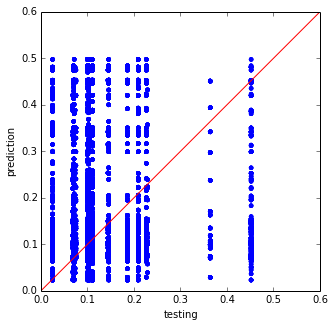

In [227]:
fig0,ax0 = plt.subplots(figsize=(5,5))
ax0.scatter(y_test.z, y_predict.z, marker='o', linewidth=0, color="blue")
ax0.plot(np.linspace(0,1), np.linspace(0,1), color="red")
ax0.set(xlabel="testing", ylabel="prediction", xlim=(0,0.6), ylim=(0,0.6))

 (0, 0.5),
 (0, 0.5),

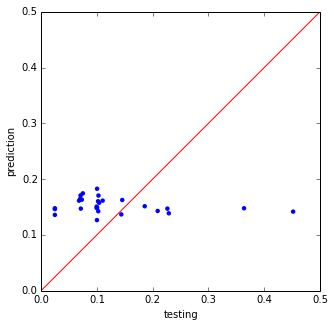

In [228]:
df_test_predict = pd.DataFrame({'y_test': y_test.z, 'y_predict':y_predict.z})
df_mean = df_test_predict.groupby('y_test', as_index=False).mean()
fig2,ax2 = plt.subplots(figsize=(5,5))
ax2.scatter(df_mean.y_test, df_mean.y_predict, marker='o', linewidth=0, color="blue")
ax2.plot(np.linspace(0,1), np.linspace(0,1), color="red")
ax2.set(xlabel="testing", ylabel="prediction", xlim=(0,0.5), ylim=(0,0.5))

 (0, 1),
 (0, 1),

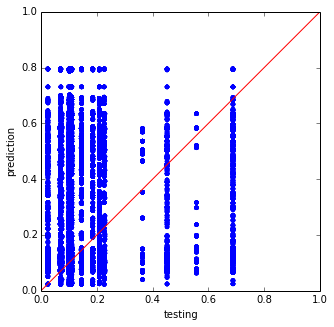

In [241]:
fig1,ax1 = plt.subplots(figsize=(5,5))
ax1.scatter(y_test.z, y_predict.z, marker='o', linewidth=0, color="blue")
ax1.plot(np.linspace(0,1), np.linspace(0,1), color="red")
ax1.set(xlabel="testing", ylabel="prediction", xlim=(0,1), ylim=(0,1))

 (0, 0.5),
 (0, 0.5),

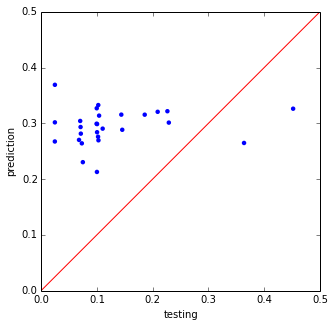

In [242]:
df_test_predict = pd.DataFrame({'y_test': y_test.z, 'y_predict':y_predict.z})
df_mean = df_test_predict.groupby('y_test', as_index=False).mean()
fig3,ax3 = plt.subplots(figsize=(5,5))
ax3.scatter(df_mean.y_test, df_mean.y_predict, marker='o', linewidth=0, color="blue")
ax3.plot(np.linspace(0,1), np.linspace(0,1), color="red")
ax3.set(xlabel="testing", ylabel="prediction", xlim=(0,0.5), ylim=(0,0.5))